In [1]:
# data source
# https://github.com/yukiar/CEFR-SP?tab=readme-ov-file 
# https://www.kaggle.com/datasets/amontgomerie/cefr-levelled-english-texts

In [2]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you 

In [3]:
import re
import pandas as pd 
import numpy as np 

from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from safetensors.torch import load_model, load_file

from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, RobertaForSequenceClassification, RobertaPreTrainedModel
from transformers import DebertaTokenizer, DebertaV2Model, DebertaConfig, DebertaForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, PreTrainedModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput

2025-04-20 01:13:29.985476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745111610.176615      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745111610.232836      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
score_dev_file = "/kaggle/input/cefr-sp-dataset/CEFR-SP_SCoRE_dev.txt"
score_test_file = "/kaggle/input/cefr-sp-dataset/CEFR-SP_SCoRE_test.txt"
score_train_file = "/kaggle/input/cefr-sp-dataset/CEFR-SP_SCoRE_train.txt"
wikiauto_dev_file = "/kaggle/input/cefr-sp-dataset/CEFR-SP_Wikiauto_dev.txt"
wikiauto_test_file = "/kaggle/input/cefr-sp-dataset/CEFR-SP_Wikiauto_test.txt"
wikiauto_train_file = "/kaggle/input/cefr-sp-dataset/CEFR-SP_Wikiauto_train.txt"

labelled_text_file = "/kaggle/input/cefr-levelled-english-texts/cefr_leveled_texts.csv"

In [5]:
label_encoder = LabelEncoder()
# model_name = 'roberta-base'
model_name = 'microsoft/deberta-v3-small'
# tokenizer = RobertaTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def prepare_CEFR_SP_data(path_one, path_two, max_length=512):
    # Load and combine
    df_one = pd.read_csv(path_one, sep='\t', header=None, names=["sentence", "label_A", "label_B"])
    df_two = pd.read_csv(path_two, sep='\t', header=None, names=["sentence", "label_A", "label_B"])
    df_all = pd.concat([df_one, df_two], ignore_index=True)
    
    # Create final label (assuming binary classification)
    # df_all["label"] = ((df_all["label_A"] + df_all["label_B"]) / 2).round().astype(int)
    # df_all["label"] = df_all["label"] - 1

    df_all["label_A"] = df_all["label_A"] - 1
    df_all["label_B"] = df_all["label_B"] - 1
    
    # Tokenize all sentences at once
    encodings = tokenizer(df_all["sentence"].tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    
    # return encodings, df_all["label"].tolist()
    return encodings, df_all["label_A"].tolist(), df_all["label_B"].tolist()

def prepare_labelled_text_file(path, max_length=512): 
    df = pd.read_csv(path, usecols=['text', 'label'])

    df['label'] = label_encoder.fit_transform(df['label'])
    
    train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
    dev_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    train_encodings = tokenizer(train_data["text"].tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    dev_encodings = tokenizer(dev_data["text"].tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    test_encodings = tokenizer(test_data["text"].tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    
    # encodings = tokenizer(df["text"].tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
   
    return train_encodings, train_data['label'].tolist(), dev_encodings, dev_data['label'].tolist(), test_encodings, test_data['label'].tolist()
    # return encodings, df['label'].tolist()

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
CEFR_SP_train_encodings, CEFR_SP_train_label_A, CEFR_SP_train_label_B = prepare_CEFR_SP_data(score_train_file, wikiauto_train_file)
CEFR_SP_dev_encodings, CEFR_SP_dev_label_A, CEFR_SP_dev_label_B = prepare_CEFR_SP_data(score_dev_file, wikiauto_dev_file)
CEFR_SP_test_encodings, CEFR_SP_test_label_A, CEFR_SP_test_label_B = prepare_CEFR_SP_data(score_test_file, wikiauto_test_file)

# text_train_encodings, text_train_labels, text_dev_encodings, text_dev_labels, text_test_encodings, text_test_labels = prepare_labelled_text_file(labelled_text_file)

# train_encodings = {key: torch.cat([CEFR_SP_train_encodings[key], text_train_encodings[key]]) for key in CEFR_SP_train_encodings}
# dev_encodings = {key: torch.cat([CEFR_SP_dev_encodings[key], text_dev_encodings[key]]) for key in CEFR_SP_dev_encodings}
# test_encodings = {key: torch.cat([CEFR_SP_test_encodings[key], text_test_encodings[key]]) for key in CEFR_SP_test_encodings}

train_encodings = CEFR_SP_train_encodings
dev_encodings = CEFR_SP_dev_encodings
test_encodings = CEFR_SP_test_encodings

# train_labels = CEFR_SP_train_labels + text_train_labels
# dev_labels = CEFR_SP_dev_labels + text_dev_labels
# test_labels = CEFR_SP_test_labels + text_test_labels

# train_labels = CEFR_SP_train_labels
# dev_labels = CEFR_SP_dev_labels
# test_labels = CEFR_SP_test_labels 

# all_labels = train_labels + dev_labels + test_labels

In [7]:
batch_size = 16
learning_rate = 5e-5
epochs = 0

In [8]:
class CEFRDataset(Dataset):
    def __init__(self, encodings, label_a, label_b):
        self.encodings = encodings
        self.label_a = label_a
        self.label_b = label_b

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['label_a'] = torch.tensor(self.label_a[idx], dtype=torch.long)
        item['label_b'] = torch.tensor(self.label_b[idx], dtype=torch.long)
        return item

In [9]:
train_dataset = CEFRDataset(train_encodings, CEFR_SP_train_label_A, CEFR_SP_train_label_B)
dev_dataset = CEFRDataset(dev_encodings, CEFR_SP_dev_label_A, CEFR_SP_dev_label_B)
test_dataset = CEFRDataset(test_encodings, CEFR_SP_test_label_A, CEFR_SP_test_label_B)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
class CustomModelWithCEFR(PreTrainedModel):
    def __init__(self, config, model_name_or_path, num_labels=6, two_labels=True):
        super().__init__(config)
        self.backbone = DebertaV2Model(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        
        self.num_labels = num_labels
        self.two_labels = two_labels

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        label_a=None,
        label_b=None,
        labels=None,
    ):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if self.two_labels:
            if label_a is not None and label_b is not None:
                loss_fn = nn.CrossEntropyLoss()
                loss_a = loss_fn(logits, label_a)
                loss_b = loss_fn(logits, label_b)
                loss = 0.5 * (loss_a + loss_b)
        else:
            if labels is not None:
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states if hasattr(outputs, 'hidden_states') else None,
            attentions=outputs.attentions if hasattr(outputs, 'attentions') else None
        )

    @classmethod
    def from_pretrained_custom(cls, model_path, **kwargs):
        config = AutoConfig.from_pretrained(model_path)
        return cls.from_pretrained(model_path, config=config, model_name_or_path=model_path, **kwargs)


In [11]:
num_labels = 6
# model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
# model = AutoModel.from_pretrained(model_name, num_labels=num_labels)

# config = RobertaConfig.from_pretrained("roberta-base")
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
# model = RobertaWithOptionalCEFRFeatures(config, class_weights=class_weights)

config = AutoConfig.from_pretrained(model_name, num_labels=6)
model = CustomModelWithCEFR(config, model_name_or_path=model_name)

In [12]:
def get_gold_labels(preds, label_a, label_b):
    # if prediction matches either label_a or label_b, take it as gold
    gold = label_a.clone()
    mask = (preds == label_b) & (preds != label_a)
    gold[mask] = label_b[mask]
    return gold

In [13]:
cefr_levels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs['loss']
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    model.eval()
    preds, true_labels = [], []
    
    with torch.no_grad():
        for batch in dev_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs['logits']
            preds += torch.argmax(logits, axis=1).tolist()
            gold_labels = get_gold_labels(
                preds=torch.argmax(logits, axis=1),
                label_a=batch['label_a'],
                label_b=batch['label_b']
            )
            true_labels += gold_labels.tolist()
    
    print(classification_report(true_labels, preds, target_names=cefr_levels))
    model.save_pretrained(f'deberta-two-labels-{epoch+1}')

In [14]:
# model.eval()
# preds, true_labels = [], []

# with torch.no_grad():
#     for batch in test_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         logits = outputs['logits']
#         preds += torch.argmax(logits, axis=1).tolist()
#         gold_labels = get_gold_labels(
#                 preds=torch.argmax(logits, axis=1),
#                 label_a=batch['label_a'],
#                 label_b=batch['label_b']
#             )
#         true_labels += gold_labels.tolist()

# print(classification_report(true_labels, preds, target_names=cefr_levels))

train with single label

In [15]:
text_train_encodings, text_train_labels, text_dev_encodings, text_dev_labels, text_test_encodings, text_test_labels = prepare_labelled_text_file(labelled_text_file)

In [16]:
class CEFRDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [17]:
learning_rate = 5e-5
batch_size = 8

In [18]:
train_dataset = CEFRDataset(text_train_encodings, text_train_labels)
dev_dataset = CEFRDataset(text_dev_encodings, text_dev_labels)
test_dataset = CEFRDataset(text_test_encodings, text_test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [55]:
cefr_levels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_2 = CustomModelWithCEFR.from_pretrained_custom("/kaggle/input/cefr-classifier-bert/pytorch/deberta/3", two_labels=False)
model_2.to(device)

CustomModelWithCEFR(
  (backbone): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [57]:
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

for epoch in range(10):
    model_2.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_2(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch.get('token_type_ids'),
            labels=batch['labels']
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    model_2.eval()
    preds, true_labels = [], []
    
    with torch.no_grad():
        for batch in dev_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model_2(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch.get('token_type_ids'),
                labels=batch['labels']
            )
            logits = outputs.logits
            preds += torch.argmax(logits, axis=1).tolist()
            true_labels += batch['labels'].tolist()
    
    print(classification_report(true_labels, preds, target_names=cefr_levels))
    model_2.save_pretrained(f'deberta-two-labels-finetune-{epoch+1}')

Epoch 1, Loss: 156.8687
              precision    recall  f1-score   support

          A1       0.93      0.72      0.81        39
          A2       0.54      0.90      0.68        21
          B1       0.69      0.55      0.61        20
          B2       0.65      0.46      0.54        24
          C1       0.50      0.72      0.59        25
          C2       0.80      0.60      0.69        20

    accuracy                           0.66       149
   macro avg       0.69      0.66      0.65       149
weighted avg       0.71      0.66      0.67       149



Epoch 2, Loss: 109.4884
              precision    recall  f1-score   support

          A1       0.84      0.97      0.90        39
          A2       0.80      0.57      0.67        21
          B1       0.82      0.45      0.58        20
          B2       0.54      0.62      0.58        24
          C1       0.55      0.72      0.62        25
          C2       0.82      0.70      0.76        20

    accuracy                           0.71       149
   macro avg       0.73      0.67      0.68       149
weighted avg       0.73      0.71      0.71       149



Epoch 3, Loss: 80.4781
              precision    recall  f1-score   support

          A1       0.97      0.77      0.86        39
          A2       0.61      0.81      0.69        21
          B1       0.50      0.15      0.23        20
          B2       0.29      0.17      0.21        24
          C1       0.38      0.76      0.51        25
          C2       0.70      0.70      0.70        20

    accuracy                           0.58       149
   macro avg       0.57      0.56      0.53       149
weighted avg       0.61      0.58      0.57       149



Epoch 4, Loss: 52.3384
              precision    recall  f1-score   support

          A1       0.86      0.97      0.92        39
          A2       0.83      0.71      0.77        21
          B1       0.81      0.65      0.72        20
          B2       0.62      0.42      0.50        24
          C1       0.47      0.60      0.53        25
          C2       0.61      0.70      0.65        20

    accuracy                           0.70       149
   macro avg       0.70      0.68      0.68       149
weighted avg       0.71      0.70      0.70       149



Epoch 5, Loss: 30.0312
              precision    recall  f1-score   support

          A1       0.92      0.85      0.88        39
          A2       0.67      0.86      0.75        21
          B1       0.81      0.65      0.72        20
          B2       0.58      0.75      0.65        24
          C1       0.62      0.60      0.61        25
          C2       0.80      0.60      0.69        20

    accuracy                           0.73       149
   macro avg       0.73      0.72      0.72       149
weighted avg       0.75      0.73      0.73       149



Epoch 6, Loss: 14.1783
              precision    recall  f1-score   support

          A1       0.89      0.87      0.88        39
          A2       0.71      0.81      0.76        21
          B1       0.82      0.70      0.76        20
          B2       0.54      0.83      0.66        24
          C1       0.74      0.56      0.64        25
          C2       0.86      0.60      0.71        20

    accuracy                           0.74       149
   macro avg       0.76      0.73      0.73       149
weighted avg       0.77      0.74      0.75       149



Epoch 7, Loss: 20.9100
              precision    recall  f1-score   support

          A1       0.87      0.87      0.87        39
          A2       0.68      0.71      0.70        21
          B1       0.75      0.30      0.43        20
          B2       0.45      0.75      0.56        24
          C1       0.54      0.52      0.53        25
          C2       0.75      0.60      0.67        20

    accuracy                           0.66       149
   macro avg       0.67      0.63      0.63       149
weighted avg       0.69      0.66      0.65       149



Epoch 8, Loss: 16.8902
              precision    recall  f1-score   support

          A1       0.85      0.85      0.85        39
          A2       0.60      0.71      0.65        21
          B1       0.81      0.65      0.72        20
          B2       0.56      0.62      0.59        24
          C1       0.58      0.60      0.59        25
          C2       0.81      0.65      0.72        20

    accuracy                           0.70       149
   macro avg       0.70      0.68      0.69       149
weighted avg       0.71      0.70      0.70       149



Epoch 9, Loss: 6.2341
              precision    recall  f1-score   support

          A1       0.90      0.69      0.78        39
          A2       0.55      0.81      0.65        21
          B1       0.82      0.70      0.76        20
          B2       0.57      0.67      0.62        24
          C1       0.57      0.68      0.62        25
          C2       0.85      0.55      0.67        20

    accuracy                           0.68       149
   macro avg       0.71      0.68      0.68       149
weighted avg       0.72      0.68      0.69       149



Epoch 10, Loss: 5.5376
              precision    recall  f1-score   support

          A1       0.85      1.00      0.92        39
          A2       0.78      0.67      0.72        21
          B1       0.85      0.55      0.67        20
          B2       0.58      0.58      0.58        24
          C1       0.53      0.80      0.63        25
          C2       1.00      0.50      0.67        20

    accuracy                           0.72       149
   macro avg       0.76      0.68      0.70       149
weighted avg       0.76      0.72      0.72       149



In [46]:
# model_2.save_pretrained("v2")
# model_2.to(device)

# model_2.eval()
# preds, true_labels = [], []

# with torch.no_grad():
#     for batch in test_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model_2(
#             input_ids=batch['input_ids'],
#             attention_mask=batch['attention_mask'],
#             token_type_ids=batch.get('token_type_ids'),
#             labels=batch['labels']
#         )
#         logits = outputs.logits
#         preds += torch.argmax(logits, axis=1).tolist()
#         true_labels += batch['labels'].tolist()

# print(classification_report(true_labels, preds, target_names=cefr_levels))

# model_2 = CustomModelWithCEFR.from_pretrained_custom("/kaggle/working/v2", two_labels=False)
# model_2.to(device)

# model_2.eval()
# preds, true_labels = [], []

# with torch.no_grad():
#     for batch in test_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model_2(
#             input_ids=batch['input_ids'],
#             attention_mask=batch['attention_mask'],
#             token_type_ids=batch.get('token_type_ids'),
#             labels=batch['labels']
#         )
#         logits = outputs.logits
#         preds += torch.argmax(logits, axis=1).tolist()
#         true_labels += batch['labels'].tolist()

# print(classification_report(true_labels, preds, target_names=cefr_levels))


              precision    recall  f1-score   support

          A1       0.79      0.68      0.73        28
          A2       0.65      0.77      0.71        31
          B1       0.56      0.56      0.56        16
          B2       0.58      0.60      0.59        30
          C1       0.54      0.54      0.54        26
          C2       0.75      0.63      0.69        19

    accuracy                           0.64       150
   macro avg       0.65      0.63      0.64       150
weighted avg       0.65      0.64      0.64       150



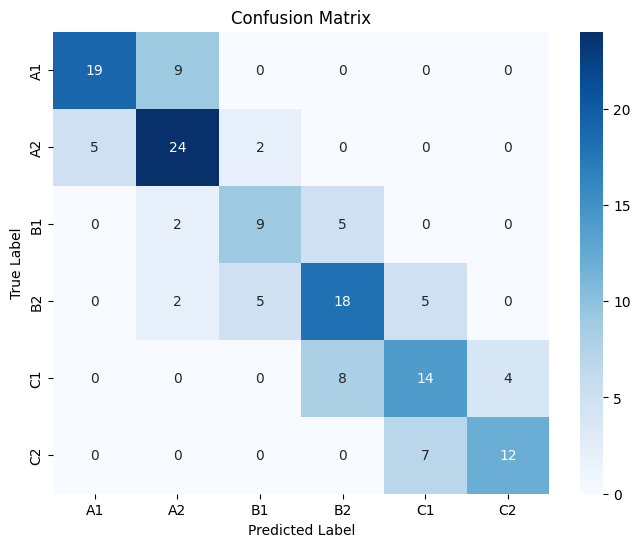

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


model_2 = CustomModelWithCEFR.from_pretrained_custom("/kaggle/working/deberta-two-labels-finetune-6", two_labels=False)
model_2.to(device)

model_2.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_2(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch.get('token_type_ids'),
            labels=batch['labels']
        )
        logits = outputs.logits
        preds += torch.argmax(logits, axis=1).tolist()
        true_labels += batch['labels'].tolist()

print(classification_report(true_labels, preds, target_names=cefr_levels))

cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cefr_levels, yticklabels=cefr_levels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [48]:
simplified_sent_file = '/kaggle/input/test-data-simplified-sentences/simplified-sentences.csv'
df = pd.read_csv(simplified_sent_file, encoding='ISO-8859-1', usecols=['id', 'sentence'])


grouped_sentences = []
current_group = None

# Create groups based on 'base' and 'variants'
for _, row in df.iterrows():
    sid, sentence = row['id'], row['sentence']
    
    if sid == 'base':
        # Start a new group
        if current_group:
            grouped_sentences.append(current_group)
        
        current_group = {  # Initialize the new group when 'base' is encountered
            'base': sentence,
            'variants': []
        }
    else:
        # Append sentence to variants if not 'base'
        if current_group:  # Ensure current_group is initialized before appending
            current_group['variants'].append({
                'id': int(sid),
                'sentence': sentence
            })

# After the loop, add the last group to grouped_sentences if it exists
if current_group:
    grouped_sentences.append(current_group)

In [49]:
import torch.nn.functional as F

cefr_levels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']


model_2.eval()

for group in grouped_sentences:
    predictions = []

    # Predict for base sentence
    base_sentence = group['base']
    inputs = tokenizer(base_sentence, return_tensors='pt', truncation=True, padding=True).to(model_2.device)

    with torch.no_grad():
        outputs = model_2(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            token_type_ids=inputs.get('token_type_ids')
        )
        logits = outputs.logits 
        probs = F.softmax(logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        base_pred = cefr_levels[pred_idx]
        predictions.append(base_pred)

    # Predict for variants
    for variant in group['variants']:
        sentence = variant['sentence']
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True).to(model_2.device)

        with torch.no_grad():
            outputs = model_2(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                token_type_ids=inputs.get('token_type_ids')
            )
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)
            pred_idx = torch.argmax(probs, dim=1).item()
            pred_label = cefr_levels[pred_idx]
            predictions.append(pred_label)

    print(f"Base: {predictions[0]}")
    print(f"Variants: {predictions[1:]}")
    print("-" * 30)


Base: B1
Variants: ['B1', 'B1', 'B2', 'B1', 'B1', 'B1', 'B2', 'B1', 'B1']
------------------------------
Base: B1
Variants: ['B1', 'B1', 'A2', 'A2', 'A2', 'A2', 'A2', 'A2', 'A2', 'B1', 'B1', 'B1']
------------------------------
Base: C1
Variants: ['B2', 'B2', 'B2', 'B2', 'B2', 'B2']
------------------------------
Base: C2
Variants: ['C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2']
------------------------------


In [52]:
model_2.save_pretrained("v2")

              precision    recall  f1-score   support

          A1       0.61      1.00      0.76        28
          A2       0.70      0.45      0.55        31
          B1       0.67      0.38      0.48        16
          B2       0.67      0.60      0.63        30
          C1       0.58      0.73      0.64        26
          C2       0.80      0.63      0.71        19

    accuracy                           0.65       150
   macro avg       0.67      0.63      0.63       150
weighted avg       0.66      0.65      0.63       150



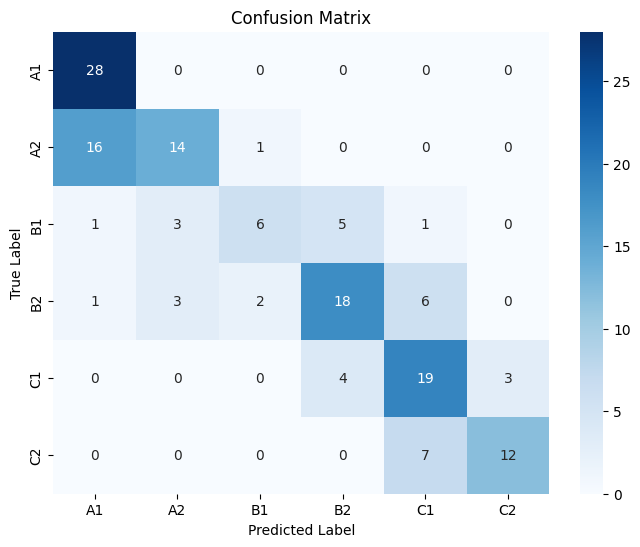

In [60]:
model_3 = CustomModelWithCEFR.from_pretrained_custom("/kaggle/working/deberta-two-labels-finetune-10", two_labels=False)
model_3.to(device)

model_3.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_3(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch.get('token_type_ids'),
            labels=batch['labels']
        )
        logits = outputs.logits
        preds += torch.argmax(logits, axis=1).tolist()
        true_labels += batch['labels'].tolist()

print(classification_report(true_labels, preds, target_names=cefr_levels))

cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cefr_levels, yticklabels=cefr_levels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [61]:
for group in grouped_sentences:
    predictions = []

    # Predict for base sentence
    base_sentence = group['base']
    inputs = tokenizer(base_sentence, return_tensors='pt', truncation=True, padding=True).to(model_2.device)

    with torch.no_grad():
        outputs = model_3(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            token_type_ids=inputs.get('token_type_ids')
        )
        logits = outputs.logits 
        probs = F.softmax(logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        base_pred = cefr_levels[pred_idx]
        predictions.append(base_pred)

    # Predict for variants
    for variant in group['variants']:
        sentence = variant['sentence']
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True).to(model_2.device)

        with torch.no_grad():
            outputs = model_3(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                token_type_ids=inputs.get('token_type_ids')
            )
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)
            pred_idx = torch.argmax(probs, dim=1).item()
            pred_label = cefr_levels[pred_idx]
            predictions.append(pred_label)

    print(f"Base: {predictions[0]}")
    print(f"Variants: {predictions[1:]}")
    print("-" * 30)

Base: B1
Variants: ['B1', 'B1', 'B1', 'B1', 'B1', 'B1', 'B1', 'B1', 'B1']
------------------------------
Base: B1
Variants: ['A2', 'B1', 'A1', 'A1', 'A2', 'A1', 'A2', 'A1', 'A2', 'B1', 'B1', 'B1']
------------------------------
Base: C1
Variants: ['B2', 'B2', 'B2', 'B2', 'B2', 'B2']
------------------------------
Base: C1
Variants: ['C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1']
------------------------------
